# Erebus Stacked Timeseries Plot

In [2]:
import scipy
import pandas as pd
import obspy
import requests
import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('pdf', fonttype=42)

plt.style.use("/home/mchristo/proj/libmsc/style/msc.mplstyle")

## Load explosion times, get 100 largest that occur when horizontal component data is available

In [3]:
# Load explosion times from Chaput (Knox?) catalog
data0 = scipy.io.loadmat("./data/Eruptions_max_times.mat")
data1 = scipy.io.loadmat("./data/eruption_times_fix.mat")

del data0["__header__"]
del data0["__version__"]
del data0["__globals__"]

del data1["__header__"]
del data1["__version__"]
del data1["__globals__"]

# Undo some weird structure from mat file reading
data1["eruption_time"] = [str(time[0]) for time in data1["eruption_time"][0]]
data0["mx"] = data0["mx"][0]

data = {"eruption_time": data1["eruption_time"], "mx": data0["mx"]}

df = pd.DataFrame(data)

# Convert times to datetime objects
df["eruption_time"] = pd.to_datetime(df["eruption_time"], format="%Y/%m/%d  %H:%M:%S")

# Window out events outside 2003-2013
df = df[df["eruption_time"] > "2003-01-01"]
df = df[df["eruption_time"] < "2013-01-01"]

# Sort by size
df = df.sort_values("mx", ascending=False)

In [10]:
def get_avail(network, station, channel, start, stop):
    # Make URL
    url = "http://service.iris.edu/fdsnws/availability/1/query?"
    url += "network=%s&" % network 
    url += "station=%s&" % station 
    url += "channel=%s&" % channel
    url += "start=%s&" % str(start)
    url += "end=%s" % str(stop)
    
    # Send request
    try:
        res = requests.get(url)
    except Exception as e:
        print(e)
        return None
    # Parse result into dataframe
    cols = ["network", "station", "location", "channel", "quality", "samplerate", "earliest", "latest"]
    df = pd.read_csv(io.StringIO(res.text), sep=" ", comment="#", header=None, names=cols)
    df["earliest"] = df["earliest"].apply(obspy.UTCDateTime)
    df["latest"] = df["latest"].apply(obspy.UTCDateTime)
    
    return df

In [11]:
# Get data availability
start = obspy.UTCDateTime("2003-01-01")
stop = obspy.UTCDateTime("2013-01-01") 
avail = get_avail("ER", "NKB,E1S", "BH1,BH2,BHE,BHN", start, stop)

In [12]:
# Get ten largest events with horizontal data available
count = 0
times = []
tbound = 60*60 # 40 minute bound
nevent = 100
# Go until nevent events with 4 channels available
for i, row in df.iterrows():
    t = obspy.UTCDateTime(row["eruption_time"])
    t0 = t - tbound # hour before
    t1 = t + tbound # hour after
    ncha = np.sum(np.logical_and(avail["earliest"] < t0, avail["latest"] > t1))
    if(ncha == 4):
        print(t)
        times.append(t)
        count += 1
    if(count == nevent):
        break

2007-02-11T05:12:35.000000Z
2007-02-07T02:54:19.000000Z
2007-02-04T05:49:28.000000Z
2007-02-16T08:34:49.000000Z
2007-02-03T09:43:34.000000Z
2007-02-14T05:12:42.000000Z
2007-02-15T01:47:29.000000Z
2007-01-25T05:04:32.000000Z
2007-02-11T11:36:07.000000Z
2007-02-09T11:22:08.000000Z
2007-02-04T02:40:48.000000Z
2007-02-22T09:05:55.000000Z
2007-02-06T10:21:31.000000Z
2007-02-01T12:33:34.000000Z
2007-02-21T03:54:20.000000Z
2007-02-14T08:09:28.000000Z
2006-01-17T01:21:31.000000Z
2007-01-30T08:55:51.000000Z
2007-01-31T09:06:00.000000Z
2007-02-10T11:32:44.000000Z
2007-01-24T10:52:03.000000Z
2007-01-08T08:02:47.000000Z
2006-01-15T08:42:53.000000Z
2006-01-31T12:03:59.000000Z
2006-03-21T09:39:50.000000Z
2007-01-20T08:47:09.000000Z
2006-03-10T04:41:46.000000Z
2007-01-28T07:26:35.000000Z
2007-02-20T01:40:08.000000Z
2007-02-13T05:51:50.000000Z
2007-02-11T08:57:32.000000Z
2007-02-08T03:49:56.000000Z
2006-03-05T07:35:51.000000Z
2007-02-16T11:25:47.000000Z
2006-03-01T12:20:40.000000Z
2005-12-19T09:39:58.

In [13]:
# Write out file for pysep
with open("./data/erebus_events_100.txt", mode="w") as fd:
    # skip second one because of data gap (pysep download fails)
    for t in times:
        fd.write("%s 167.1523 -77.5293 0 0\n" % str(t))

In [14]:
# Load times
times = []
with open("./data/erebus_events_100.txt", mode="r") as fd:
    for line in fd:
        times.append(obspy.UTCDateTime(line.split(" ")[0]))

## Grab data with pysep and estimate tilt

In [8]:
!pysep -o -c ./data/erebus_pysep.yaml -E ./data/erebus_events.txt
!mv *VICTORIA* data/seis

[2024-10-03 13:37:42] - pysep - INFO: looping over 100 events for event file run
[2024-10-03 13:37:42] - pysep - DEBUG: running PySEP version 0.6.1
[2024-10-03 13:37:42] - pysep - INFO: will NOT overwrite event search parameters (including origin and reference time) with config file
[2024-10-03 13:37:42] - pysep - INFO: overwriting default parameters with config file: './data/erebus_pysep.yaml'
[2024-10-03 13:37:42] - pysep - DEBUG: event_tag: None -> Erebus
[2024-10-03 13:37:42] - pysep - DEBUG: seconds_before_ref: 100 -> 3600
[2024-10-03 13:37:42] - pysep - DEBUG: seconds_after_ref: 300 -> 3600
[2024-10-03 13:37:42] - pysep - DEBUG: networks: * -> ER
[2024-10-03 13:37:42] - pysep - DEBUG: stations: * -> NKB,E1S
[2024-10-03 13:37:42] - pysep - DEBUG: channels: * -> BH?
[2024-10-03 13:37:42] - pysep - DEBUG: demean: True -> False
[2024-10-03 13:37:42] - pysep - DEBUG: detrend: True -> False
[2024-10-03 13:37:42] - pysep - DEBUG: remove_response: True -> False
[2024-10-03 13:37:42] - py

In [21]:
#!seinei -v -f 60001 -pbl 600 -pbs 60 ./data/seis/2007-01-25T050432_VICTORIA_LAND_ANTARCTICA/inv.xml ./data/seis/*VICTORIA*/SAC/20*.sac
!seinei -v -a -f 4 -pbl 3600 -pbs 120 ./data/seis/2007-01-25T050432_VICTORIA_LAND_ANTARCTICA/inv.xml ./data/seis/*VICTORIA*/SAC/20*.sac

Reading inventory file:
	./data/seis/2007-01-25T050432_VICTORIA_LAND_ANTARCTICA/inv.xml
Reading SAC file(s):
	./data/seis/2005-12-15T093055_VICTORIA_LAND_ANTARCTICA/SAC/2005-12-15T093055_VICTORIA_LAND_ANTARCTICA.ER.E1S..BH1.sac
	./data/seis/2005-12-15T093055_VICTORIA_LAND_ANTARCTICA/SAC/2005-12-15T093055_VICTORIA_LAND_ANTARCTICA.ER.E1S..BH2.sac
	./data/seis/2005-12-15T093055_VICTORIA_LAND_ANTARCTICA/SAC/2005-12-15T093055_VICTORIA_LAND_ANTARCTICA.ER.E1S..BHZ.sac
	./data/seis/2005-12-15T093055_VICTORIA_LAND_ANTARCTICA/SAC/2005-12-15T093055_VICTORIA_LAND_ANTARCTICA.ER.NKB..BH1.sac
	./data/seis/2005-12-15T093055_VICTORIA_LAND_ANTARCTICA/SAC/2005-12-15T093055_VICTORIA_LAND_ANTARCTICA.ER.NKB..BH2.sac
	./data/seis/2005-12-15T093055_VICTORIA_LAND_ANTARCTICA/SAC/2005-12-15T093055_VICTORIA_LAND_ANTARCTICA.ER.NKB..BHZ.sac
	./data/seis/2005-12-19T034020_VICTORIA_LAND_ANTARCTICA/SAC/2005-12-19T034020_VICTORIA_LAND_ANTARCTICA.ER.E1S..BH1.sac
	./data/seis/2005-12-19T034020_VICTORIA_LAND_ANTARCTICA/SA

## Load and plot tilt

In [22]:
st = obspy.Stream()

print("Loading %d events" % len(times))
for i in range(len(times)):
    # Make file name
    datetime = str(times[i]).split(".")[0].replace(":", "")
    st += obspy.read("./data/seis/%s_VICTORIA_LAND_ANTARCTICA/SAC/tilt*.sac" % datetime)

#st = obspy.read("./data/seis/*VICTORIA*/SAC/tilt*.sac")
tbound = 60*40 # 40 minute bound


Loading 100 events


fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail


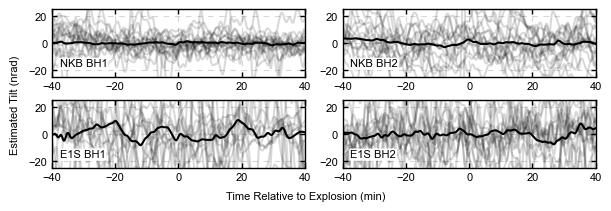

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(6,2), constrained_layout=True)
min_in_day = 60*24
sealpha = .15

# NKB BH1
nkb_exclude = [31, 44, 48]
mrec = np.zeros_like(st.select(station="NKB", channel="BH1").slice(starttime=times[0]-3600, endtime=times[0]+3600)[0].data)
for i, t in enumerate(times):
    if(i in nkb_exclude):
        continue
    tr = st.select(station="NKB", channel="BH1").slice(starttime=t-3600, endtime=t+3600)[0]
    data = tr.data
    trel = tr.times("matplotlib") - t.matplotlib_date

    try:
        mrec += data
        if(not (i % 5)):
            axs[0,0].plot(trel*min_in_day, data*1e9, "k-", alpha=sealpha)
    except:
        print("fail")
        continue
    
mrec /= len(times)
axs[0,0].plot(trel*min_in_day, mrec*1e9, "k")
axs[0,0].set_ylim(-25, 25)
#axs[0,0].set_title("NKB BH1", fontsize=8)
axs[0,0].annotate(
    "NKB BH1",
    xy=(0.03, 0.15),
    xycoords="axes fraction", 
    fontsize=8,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')
)

# NKB BH2
mrec = np.zeros_like(st.select(station="NKB", channel="BH2").slice(starttime=times[0]-tbound, endtime=times[0]+tbound)[0].data)
for i, t in enumerate(times):
    if(i in nkb_exclude):
        continue
    tr = st.select(station="NKB", channel="BH2").slice(starttime=t-tbound, endtime=t+tbound)[0]
    data = tr.data
    trel = tr.times("matplotlib") - t.matplotlib_date
    try:
        mrec += data
        if(not (i % 5)):
            axs[0,1].plot(trel*min_in_day, data*1e9, "k-", alpha=sealpha)
    except:
        print("fail")
        continue
        
mrec /= len(times)
axs[0,1].plot(trel*min_in_day, mrec*1e9, "k")
axs[0,1].set_ylim(-25, 25)
#axs[0,1].set_title("NKB BH2", fontsize=8)
axs[0,1].annotate(
    "NKB BH2",
    xy=(0.03, 0.15),
    xycoords="axes fraction", 
    fontsize=8,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')
)

# E1S BH1
e1s_exclude = [44]
mrec = np.zeros_like(st.select(station="E1S", channel="BH1").slice(starttime=times[0]-tbound, endtime=times[0]+tbound)[0].data)
for i, t in enumerate(times):
    if(i in e1s_exclude):
        continue
    tr = st.select(station="E1S", channel="BH1").slice(starttime=t-tbound, endtime=t+tbound)[0]
    data = tr.data
    trel = tr.times("matplotlib") - t.matplotlib_date
    try:
        mrec += data
        if(not (i % 5)):
            axs[1,0].plot(trel*min_in_day, data*1e9, "k-", alpha=sealpha)
    except:
        print("fail")
        continue
        
mrec /= len(times)
axs[1,0].plot(trel*min_in_day, mrec*1e9, "k")
axs[1,0].set_ylim(-25, 25)
#axs[1,0].set_title("E1S BH1", fontsize=8)
axs[1,0].annotate(
    "E1S BH1",
    xy=(0.03, 0.15),
    xycoords="axes fraction", 
    fontsize=8,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')
)

# E1S BH2
mrec = np.zeros_like(st.select(station="E1S", channel="BH2").slice(starttime=times[0]-tbound, endtime=times[0]+tbound)[0].data)
for i, t in enumerate(times):
    if(i in e1s_exclude):
        continue
    tr = st.select(station="E1S", channel="BH2").slice(starttime=t-tbound, endtime=t+tbound)[0]
    data = tr.data
    trel = tr.times("matplotlib") - t.matplotlib_date
    try:
        mrec += data
        if(not (i % 5)):
            axs[1,1].plot(trel*min_in_day, data*1e9, "k-", alpha=sealpha)
    except:
        print("fail")
        continue

mrec /= len(times)
axs[1,1].plot(trel*min_in_day, mrec*1e9, "k")
axs[1,1].set_ylim(-25, 25)
#axs[1,1].set_title("E1S BH2", fontsize=8)
axs[1,1].annotate(
    "E1S BH2",
    xy=(0.03, 0.15),
    xycoords="axes fraction", 
    fontsize=8,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')
)

#for ax in axs.flatten():
#    ax.axhline(0.02, color="r", linestyle="--", linewidth=0.5)
#    ax.axhline(-0.02, color="r", linestyle="--", linewidth=0.5)

# Settings for all axes
for ax in axs.flatten():
    ax.set_xlim(-tbound/60, tbound/60)

fig.supxlabel("Time Relative to Explosion (min)", fontsize=8)
fig.supylabel("Estimated Tilt (nrad)", fontsize=8)
fig.savefig("./figs/erebus_timeseries.pdf", bbox_inches="tight")

fig.savefig("./figs/png/erebus_timeseries.png", bbox_inches="tight", dpi=300)

## Only mean records

1.9732826483931376
3.552849126009505
7.398531565172561
5.441078698709134


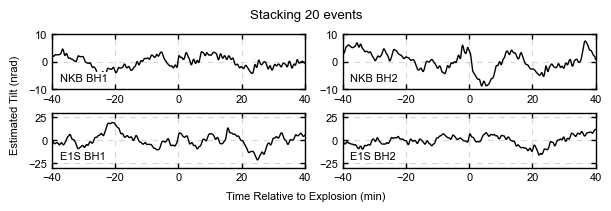

In [113]:
fig, axs = plt.subplots(2, 2, figsize=(6,2), constrained_layout=True)
min_in_day = 60*24
sealpha = .15

# NKB BH1
c = 0
n = 0
mrec = np.zeros_like(st.select(station="NKB", channel="BH1").slice(starttime=times[0]-3600, endtime=times[0]+3600)[0].data)
for t in times:
    tr = st.select(station="NKB", channel="BH1").slice(starttime=t-3600, endtime=t+3600)[0]
    data = tr.data
    trel = tr.times("matplotlib") - t.matplotlib_date

    try:
        mrec += data
        n += 1
    except:
        print("fail")
        continue
    c += 1
    if(c == 40):
        break

mrec /= n
print(np.std(mrec)*1e9)
axs[0,0].plot(trel*min_in_day, mrec*1e9, "k", linewidth=1)
axs[0,0].set_ylim(-10, 10)
#axs[0,0].set_title("NKB BH1", fontsize=8)
axs[0,0].annotate(
    "NKB BH1",
    xy=(0.03, 0.15),
    xycoords="axes fraction", 
    fontsize=8,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')
)

# NKB BH2
mrec = np.zeros_like(st.select(station="NKB", channel="BH2").slice(starttime=times[0]-tbound, endtime=times[0]+tbound)[0].data)
c = 0
n = 0
for t in times:
    if(c in [31, 44, 48]):
        continue
    c += 1
    tr = st.select(station="NKB", channel="BH2").slice(starttime=t-tbound, endtime=t+tbound)[0]
    data = tr.data
    trel = tr.times("matplotlib") - t.matplotlib_date
    try:
        mrec += data
        n += 1
    except:
        print("fail")
        continue
        
mrec /= n
print(np.std(mrec)*1e9)
axs[0,1].plot(trel*min_in_day, mrec*1e9, "k", linewidth=1)
axs[0,1].set_ylim(-10, 10)
#axs[0,1].set_title("NKB BH2", fontsize=8)
axs[0,1].annotate(
    "NKB BH2",
    xy=(0.03, 0.15),
    xycoords="axes fraction", 
    fontsize=8,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')
)

# E1S BH1
mrec = np.zeros_like(st.select(station="E1S", channel="BH1").slice(starttime=times[0]-tbound, endtime=times[0]+tbound)[0].data)
c = 0
n = 0
for t in times:
    if(c == 44):
        continue
        c += 1
    tr = st.select(station="E1S", channel="BH1").slice(starttime=t-tbound, endtime=t+tbound)[0]
    data = tr.data
    trel = tr.times("matplotlib") - t.matplotlib_date
    try:
        mrec += data
        n += 1
    except:
        print("fail")
        continue
        
mrec /= n
print(np.std(mrec)*1e9)
axs[1,0].plot(trel*min_in_day, mrec*1e9, "k", linewidth=1)
axs[1,0].set_ylim(-30, 30)
#axs[1,0].set_title("E1S BH1", fontsize=8)
axs[1,0].annotate(
    "E1S BH1",
    xy=(0.03, 0.15),
    xycoords="axes fraction", 
    fontsize=8,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')
)

# E1S BH2
mrec = np.zeros_like(st.select(station="E1S", channel="BH2").slice(starttime=times[0]-tbound, endtime=times[0]+tbound)[0].data)
n = 0
for t in times:
    tr = st.select(station="E1S", channel="BH2").slice(starttime=t-tbound, endtime=t+tbound)[0]
    data = tr.data
    trel = tr.times("matplotlib") - t.matplotlib_date
    try:
        mrec += data
        n += 1
    except:
        print("fail")
        continue



mrec /= n
print(np.std(mrec)*1e9)
axs[1,1].plot(trel*min_in_day, mrec*1e9, "k", linewidth=1)
axs[1,1].set_ylim(-30, 30)
#axs[1,1].set_title("E1S BH2", fontsize=8)
axs[1,1].annotate(
    "E1S BH2",
    xy=(0.03, 0.15),
    xycoords="axes fraction", 
    fontsize=8,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.1')
)

#for ax in axs.flatten():
#    ax.axhline(0.02, color="r", linestyle="--", linewidth=0.5)
#    ax.axhline(-0.02, color="r", linestyle="--", linewidth=0.5)

# Settings for all axes
for ax in axs.flatten():
    ax.set_xlim(-tbound/60, tbound/60)

fig.supxlabel("Time Relative to Explosion (min)", fontsize=8)
fig.supylabel("Estimated Tilt (nrad)", fontsize=8)
fig.savefig("./figs/erebus_timeseries.pdf", bbox_inches="tight")
fig.suptitle("Stacking 20 events")

fig.savefig("./figs/png/erebus_timeseries_meanonly_stack20.png", bbox_inches="tight", dpi=300)

In [115]:
1 + 3 + 7 + 5

16

In [1]:
import scipy

In [36]:
b = scipy.signal.firwin(2*3600*100+1, [1/3600, 1/60], fs=100, pass_zero=False)

In [37]:
w, gd = scipy.signal.group_delay((1, b), fs=100)

/tmp/ipykernel_30304/3151887295.py:1: UserWarning: The filter's denominator is extremely small at frequencies [0.761, 0.810, 0.859, 0.908, 0.957, 1.006, 1.055, 1.104, 1.154, 1.203, 1.252, 1.301, 1.350, 1.399, 1.448, 1.497, 1.546, 1.595, 1.644, 1.694, 1.743, 1.792, 1.841, 1.890, 1.939, 1.988, 2.037, 2.086, 2.135, 2.184, 2.233, 2.283, 2.332, 2.381, 2.430, 2.479, 2.528, 2.577, 2.626, 2.675, 2.724, 2.773, 2.823, 2.872, 2.921, 2.970, 3.019, 3.068, 3.117],             around which a singularity may be present
  w, gd = scipy.signal.group_delay((1, b), fs=100)


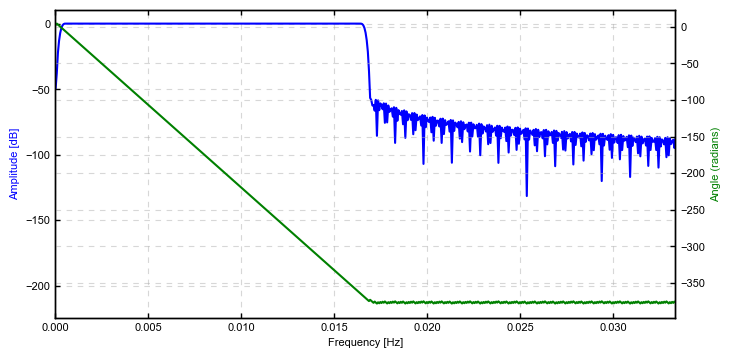

In [38]:
f = np.linspace(1/60000, 1, 2**14)

w, h = scipy.signal.freqz(b, 1, fs=100, worN=f)
fig, ax1 = plt.subplots()
ax1.plot(w, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [Hz]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid(True)
ax2.axis('tight')
ax1.set_xlim(0, 1/30)
plt.show()


In [14]:
f

array([1.66666667e-05, 2.60862841e-04, 5.05059015e-04, ...,
       9.99511608e-01, 9.99755804e-01, 1.00000000e+00])

## Individual Records

[(-10.0, 10.0), Text(0.5, 1.0, 'NKB BH1')]

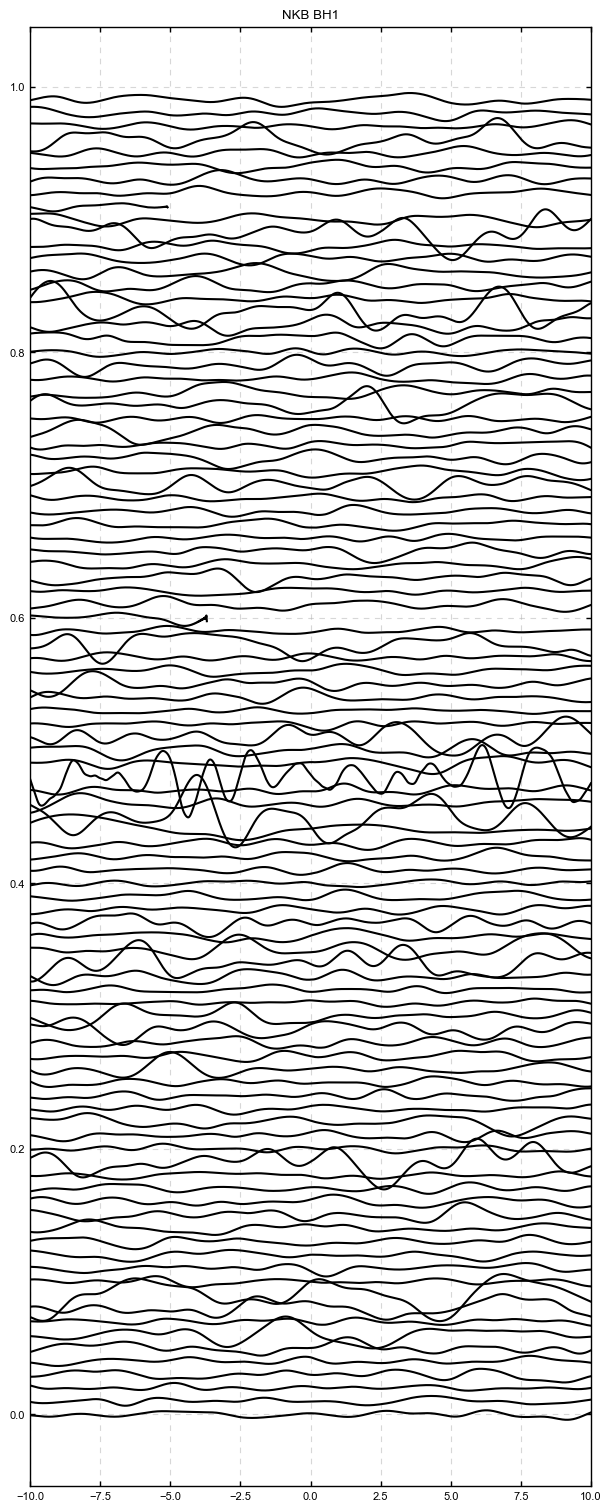

In [29]:
min_in_day = 60*24

# NKB BH1
fig, ax = plt.subplots(1, 1, figsize=(6,15), constrained_layout=True)
ofst = 1e-2
mrec = np.zeros_like(st.select(station="NKB", channel="BH1").slice(starttime=times[0]-600, endtime=times[0]+600)[0].data)
for i, t in enumerate(times):
    tr = st.select(station="NKB", channel="BH1").slice(starttime=t-600, endtime=t+600)[0]
    data = tr.data*1e6
    trel = tr.times("matplotlib") - t.matplotlib_date

    ax.plot(trel*min_in_day, data + ofst*i, "k-")
ax.set(xlim=(-10, 10), title="NKB BH1")

[(-60.0, 60.0), Text(0.5, 1.0, 'NKB BH2')]

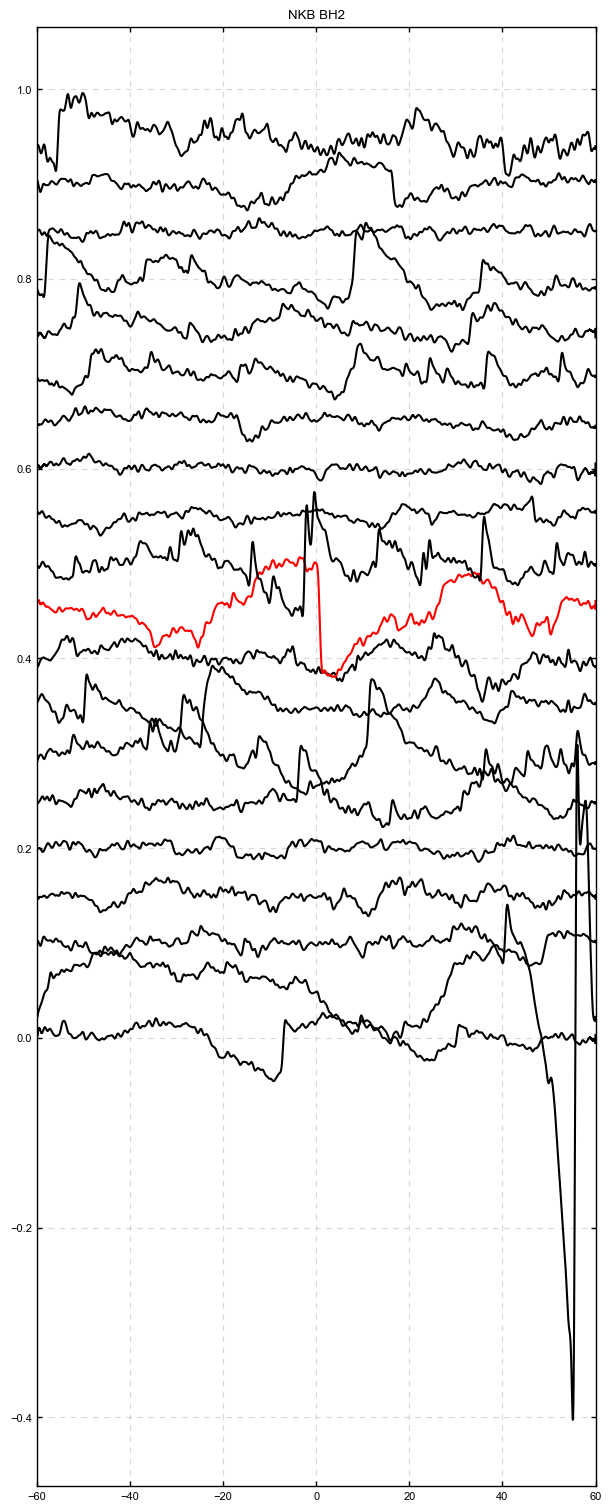

In [98]:
min_in_day = 60*24

# NKB BH2
fig, ax = plt.subplots(1, 1, figsize=(6,15), constrained_layout=True)
ofst = 5e-2
mrec = np.zeros_like(st.select(station="NKB", channel="BH2").slice(starttime=times[0]-3600, endtime=times[0]+3600)[0].data)
for i, t in enumerate(times):
    tr = st.select(station="NKB", channel="BH2").slice(starttime=t-3600, endtime=t+3600)[0]
    data = tr.data*1e6
    trel = tr.times("matplotlib") - t.matplotlib_date

    if(i == 9):
        ax.plot(trel*min_in_day, data + ofst*i, "r-")
    else:
        ax.plot(trel*min_in_day, data + ofst*i, "k-")
        
ax.set(xlim=(-60, 60), title="NKB BH2")

[(-60.0, 60.0), Text(0.5, 1.0, 'NKB BH2')]

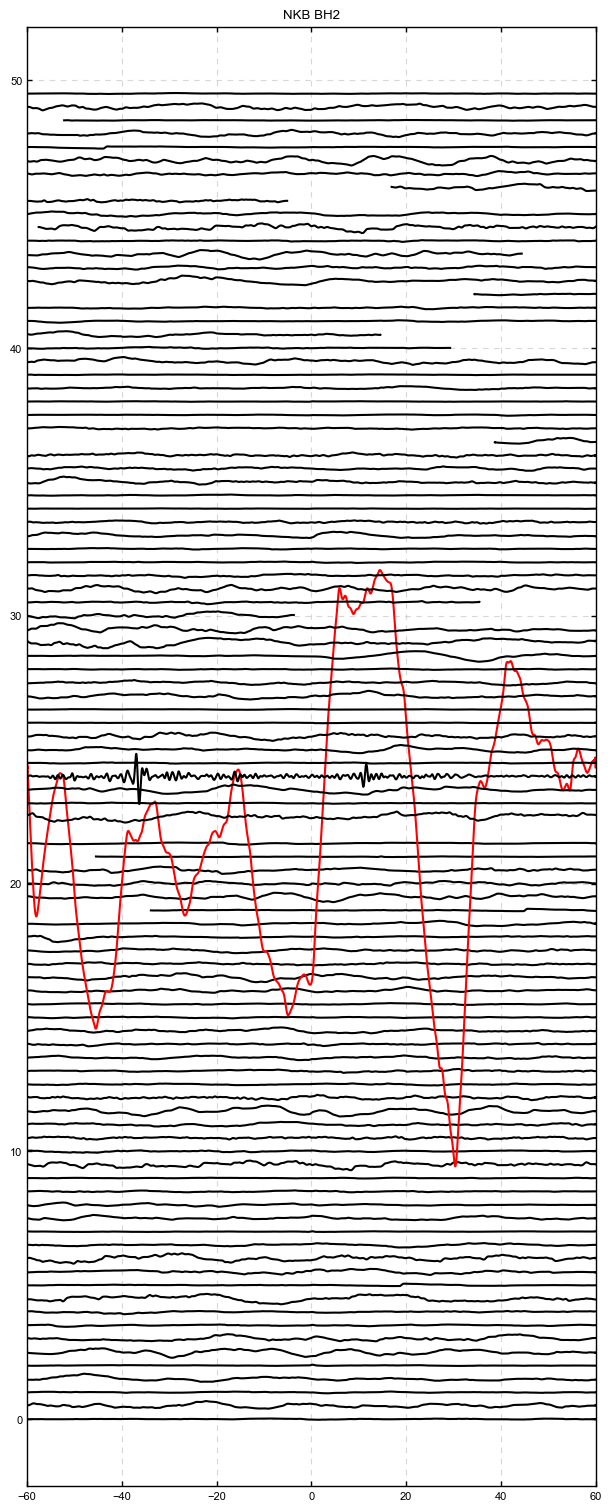

In [81]:
min_in_day = 60*24

# E1S BH1
fig, ax = plt.subplots(1, 1, figsize=(6,15), constrained_layout=True)
ofst = 5e-1
mrec = np.zeros_like(st.select(station="E1S", channel="BH1").slice(starttime=times[0]-3600, endtime=times[0]+3600)[0].data)
for i, t in enumerate(times):
    tr = st.select(station="E1S", channel="BH1").slice(starttime=t-3600, endtime=t+3600)[0]
    data = tr.data*1e6
    trel = tr.times("matplotlib") - t.matplotlib_date

    if(i == 44):
        ax.plot(trel*min_in_day, data + ofst*i, "r-")
    else:
        ax.plot(trel*min_in_day, data + ofst*i, "k-")
ax.set(xlim=(-60, 60), title="NKB BH2")